In [39]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from datetime import datetime
import numpy as np
import timeit
import json
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import itertools



In [2]:
main_df = pd.read_csv('main_df.csv')

In [3]:
main_df.head(1)

,project_id,outcome_state,final_usd_pledged,final_backers_count,project_name,project_description,live_state,in_mid_duration_range,usd_goal,usd_pledged,currency,launched_at,deadline,staff_pick,country,main_category,duration,days_from_launch,backers_count,project_link,creator_link,pledged_to_goal_ratio,description_len
0,464921389,successful,5660.0,40,Good Fishermen Know A Lot About Sex,A musical dramedy about family and dealing wit...,live,True,5000.0,1575.0,USD,08-21-2019,10-11-2019,False,US,Theater,50,21,24,https://www.kickstarter.com/projects/213094288...,https://www.kickstarter.com/profile/2130942887,0.315,58


In [4]:
model_cols = ['usd_goal', 'pledged_to_goal_ratio', 'duration', 'staff_pick',
              'country', 'main_category', 'backers_count', 'description_len', 'outcome_state']
continuous_cols = ['usd_goal', 'duration', 'backers_count', 'pledged_to_goal_ratio', 'description_len']
categorical_cols = ['staff_pick', 'country', 'main_category']

drop_cols = list(set(main_df.columns.to_list()) - set(model_cols))

In [5]:
# create model_df 
model_df = main_df.drop(drop_cols, axis=1)
model_df.head(1)

,outcome_state,usd_goal,staff_pick,country,main_category,duration,backers_count,pledged_to_goal_ratio,description_len
0,successful,5000.0,False,US,Theater,50,24,0.315,58


In [6]:
# encoding binary variables 
model_df['outcome_state'] = model_df['outcome_state'].map({'successful': 1, 'failed': 0})
model_df['staff_pick'] = model_df['staff_pick'].astype(int)


In [7]:
model_df.head(3)

,outcome_state,usd_goal,staff_pick,country,main_category,duration,backers_count,pledged_to_goal_ratio,description_len
0,1,5000.0,0,US,Theater,50,24,0.31500,58
1,0,1000.0,0,US,Crafts,45,2,0.00600,117
2,0,25000.0,0,US,Film & Video,45,2,0.00008,78


In [9]:
model_feats = model_df.drop('outcome_state', axis=1)

In [16]:
model_df.corr() > .5

,outcome_state,usd_goal,staff_pick,duration,backers_count,pledged_to_goal_ratio,description_len
outcome_state,True,False,False,False,False,False,False
usd_goal,False,True,False,False,False,False,False
staff_pick,False,False,True,False,False,False,False
duration,False,False,False,True,False,False,False
backers_count,False,False,False,False,True,False,False
pledged_to_goal_ratio,False,False,False,False,False,True,False
description_len,False,False,False,False,False,False,True


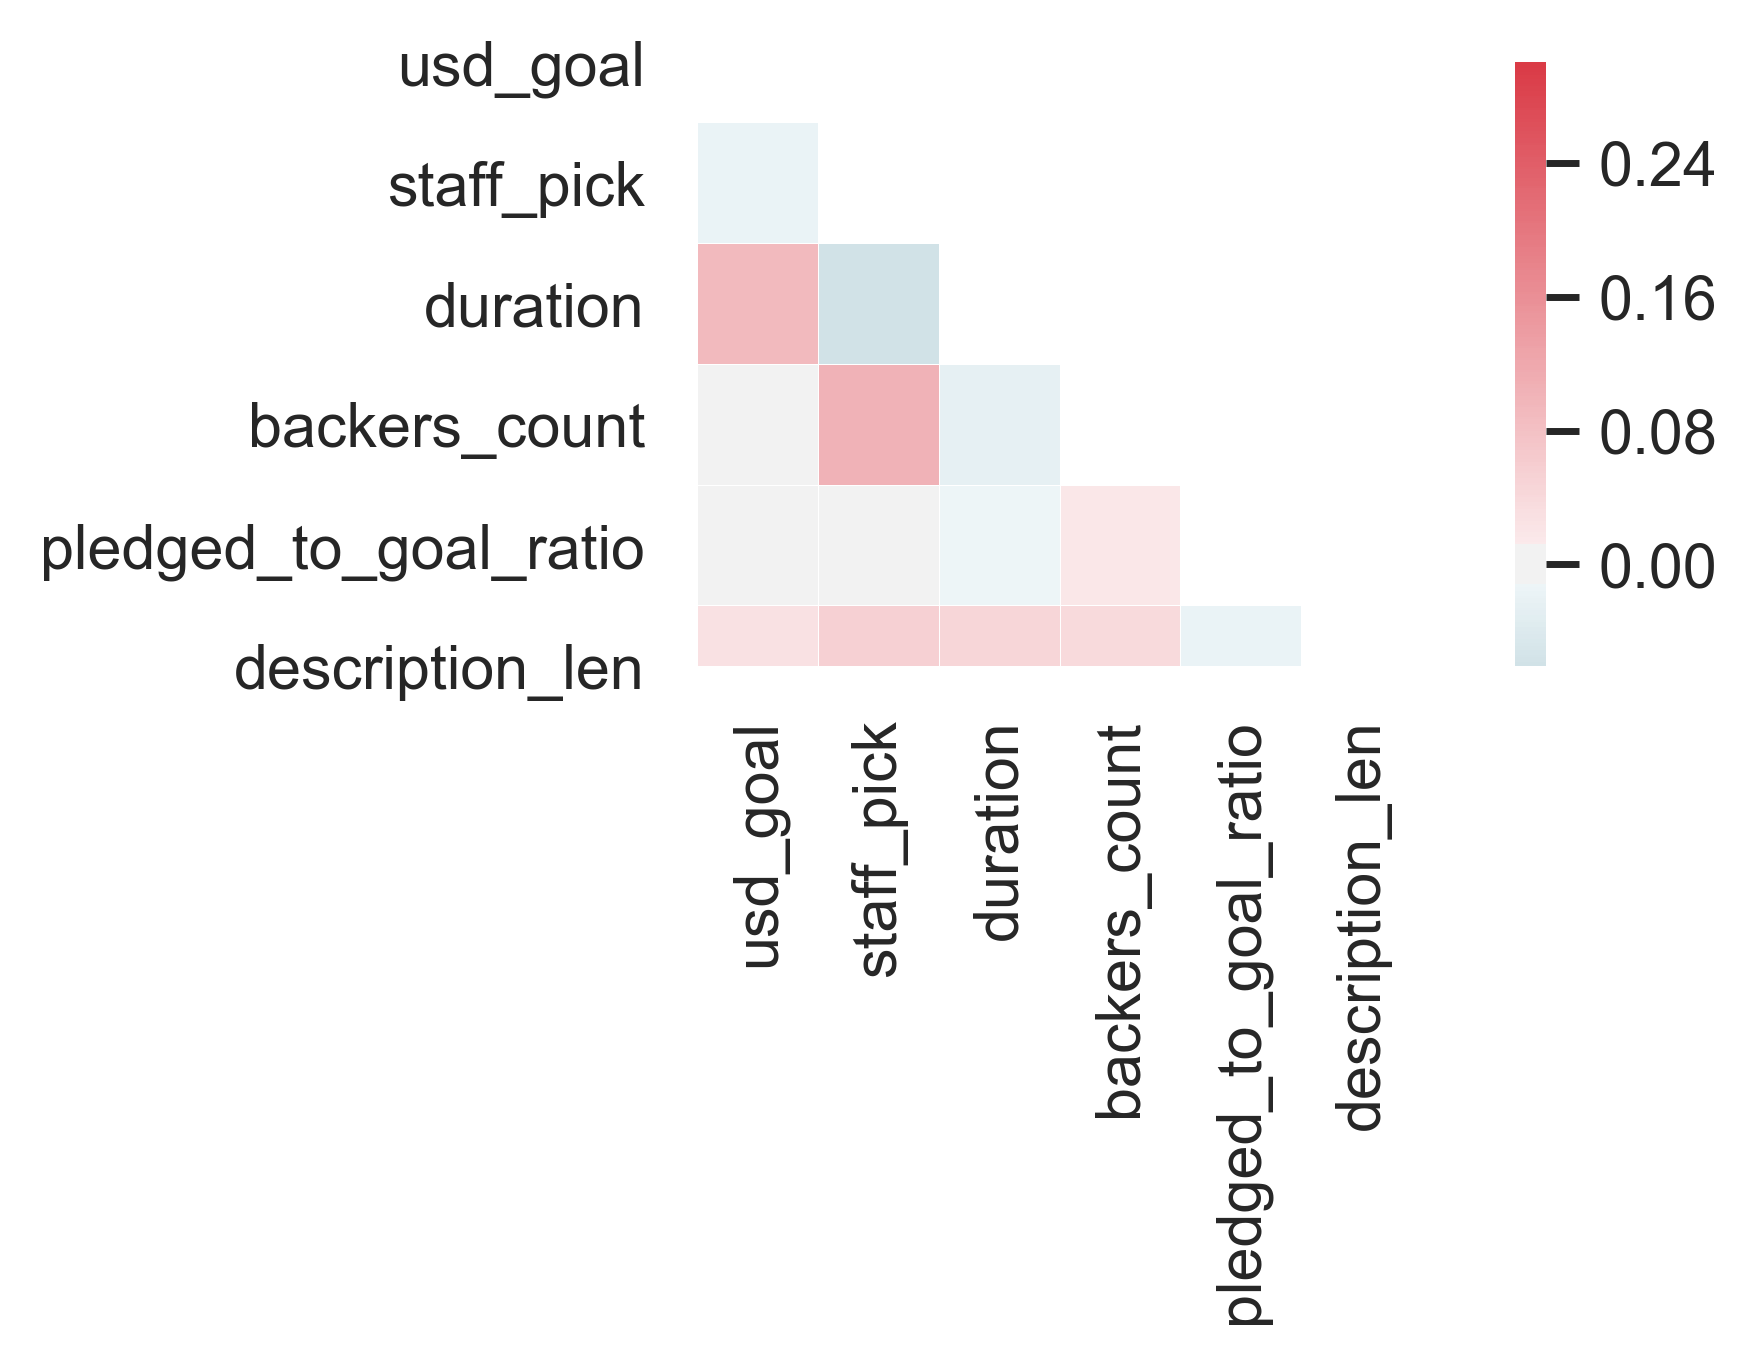

In [139]:
from string import ascii_letters
%matplotlib inline

sns.set(style="white")

# Compute the correlation matrix
corr = model_feats.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 2), dpi=400,)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plotting_context("notebook", font_scale=5.5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, label='small', linewidths=.01, cbar_kws={"shrink": 1}, annot_kws={"size":.1}, yticklabels=True)

In [31]:
# Function to dummy categorical variables
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [32]:
dummy_model_df = dummy_df(model_df, ['country', 'main_category'])

X = dummy_model_df.drop('outcome_state', axis=1)
y = dummy_model_df.loc[:, 'outcome_state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=60)

In [33]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    t if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## SVM


In [35]:
svm = SVC(gamma = 'auto')
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_test)

In [40]:
# Confusion matrix metrics
print(f"Precision Score (Test): {precision_score(y_test, svm_preds)}")
print(f"Recall Score (Test): {recall_score(y_test, svm_preds)}")
print(f"accuracy Score (Test): {accuracy_score(y_test, svm_preds)}")
print(f"F1 Score (Test): {f1_score(y_test, svm_preds)}")


Precision Score (Test): 0.7095541401273885
Recall Score (Test): 0.9911032028469751
accuracy Score (Test): 0.7202881152460985
F1 Score (Test): 0.8270230141054195


In [115]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, pad=40)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [116]:
confusion = confusion_matrix(y_test, svm_preds)
classes = ['Failed', 'Succeded']

Confusion Matrix, without normalization
[[ 43 228]
 [  5 557]]


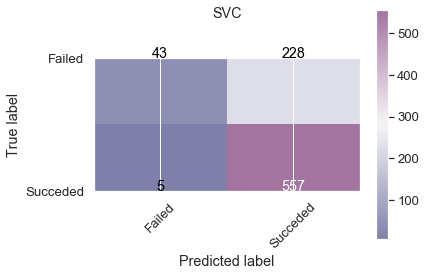

In [117]:
cmap = sns.diverging_palette(625,670, as_cmap=True, s=30, l=55)
# set_context(font_scale=1.4)
sns.set(font_scale=1.2)
# c = plotting_context("notebook", font_scale=1.5)
plot_confusion_matrix(confusion, classes,
                          normalize=False,
                          title='SVC',
                          cmap=cmap)


## DUMMY


In [128]:
#  import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
# DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X_test)
# array([1, 1, 1, 1])
# dummy_clf.score(X, y)
# 0.75

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [124]:
dummy_clf

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [129]:
dummy_clf.get_params()

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}

In [141]:
dummy_clf.score(X_train, y_train)

0.6778846153846154

###### 

In [149]:
metrics = [[0.954385964912281, 0.953125,0.93109243697479,0.950877192982456,0.954545454545455,0.959507042253521,0.946808510638298,0.86115992970123,0.709554140127389], 
[0.96797153024911, 0.976868327402135,0.98576512455516,0.9644128113879,0.97153024911032,0.969750889679715,0.950177935943061,0.871886120996441,0.991103202846975],
[0.94717887154862, 0.951980792316927,0.941176470588235,0.957597173144876,0.962962962962963,0.964601769911505,0.930372148859544,0.866489832007073,0.720288115246099],
[0.96113074204947, 0.964850615114236,0.957649092480553,0.942376950780312,0.949579831932773,0.951980792316927,0.948490230905861,0.818727490996399,0.82702301410542]]


In [150]:
columns = ['Decision Tree (depth=2)','Boosted Trees','Random Forest','ADA boost','Gradient Boost','XGBoost','Logistic Regression','KNN','SVM']
index = ['Precision', 'Recall','F1 Score', 'Accuracy']

In [152]:
heatmap_df = pd.DataFrame(data=metrics, columns=columns, index=index)

In [153]:
heatmap_df

,Decision Tree (depth=2),Boosted Trees,Random Forest,ADA boost,Gradient Boost,XGBoost,Logistic Regression,KNN,SVM
Precision,0.954386,0.953125,0.931092,0.950877,0.954545,0.959507,0.946809,0.861160,0.709554
Recall,0.967972,0.976868,0.985765,0.964413,0.971530,0.969751,0.950178,0.871886,0.991103
F1 Score,0.947179,0.951981,0.941176,0.957597,0.962963,0.964602,0.930372,0.866490,0.720288
Accuracy,0.961131,0.964851,0.957649,0.942377,0.949580,0.951981,0.948490,0.818727,0.827023


In [167]:
cmap1 = sns.diverging_palette(0,250, as_cmap=True, s=30, l=55)


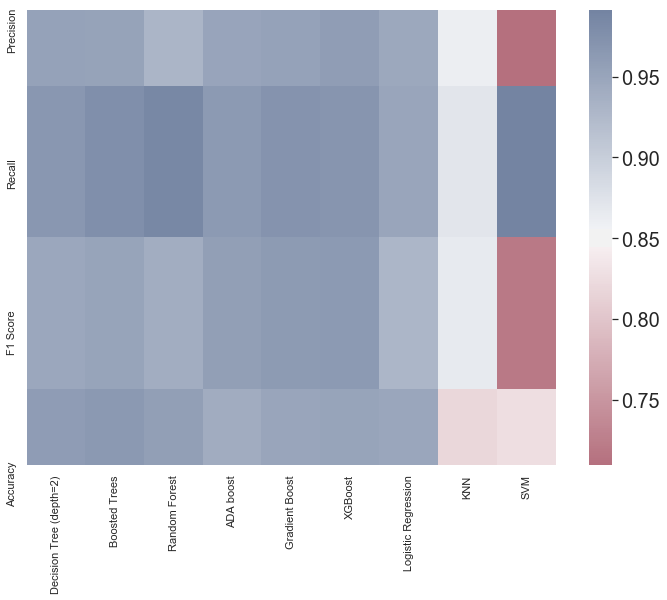

In [202]:
fig, ax = plt.subplots(figsize=(10, 7))        
plt.tight_layout()
sns.set(font_scale=1.8) 
sns.heatmap(heatmap_df, cmap=cmap1)
